In [1]:
%matplotlib inline
import pandas as pd
import glob
import os
import sys
sys.path.append(r'C:\Users\Qixin\.conda\envs\ephy\Lib\site-packages')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from build_unit import *
from scipy.stats import zscore
from scipy.signal import find_peaks
from scipy import stats
pathname=r'C:\Users\Qixin\OneDrive\Lab_stuff\EPHY_Qiushou\Ctx_discrimination_data\All'
filelist=glob.glob(os.path.join(pathname,'*.pkl'))

## Import all units (saved as pickle file, each unit is a class variable with built-in class methods)

In [2]:
#Combine units into a list called ensemble
ensemble=[]
for filename in filelist:
    ensemble.append(pd.read_pickle(filename)) 

## Evaluate the distribution of context trasversal time

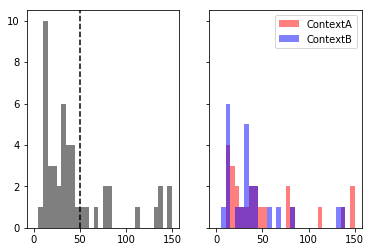

In [7]:
animal_id=[]
all_trials={'context':[],
           'duration':[]}
for unit in ensemble: 
    if unit.animal_id not in animal_id:
        animal_id.append(unit.animal_id)
        for ctx,dur in zip(unit.marker.protocol,unit.marker.door['duration']):
            all_trials['context'].append(ctx)
            all_trials['duration'].append(dur)
nbins=30
binrange=(0,150)
fig,ax=plt.subplots(1,2,sharey=True,sharex=True)
_=ax[0].hist(all_trials['duration'],nbins,binrange,color='k',alpha=0.5)
ax[0].axvline(x=50,color='k',linestyle='--')
_=ax[1].hist(np.extract(np.array(all_trials['context'])=='A',all_trials['duration']),nbins,binrange,color='red',alpha=0.5)
_=ax[1].hist(np.extract(np.array(all_trials['context'])=='B',all_trials['duration']),nbins,binrange,color='blue',alpha=0.5)
_=ax[1].legend(['ContextA','ContextB'])
fig.savefig(os.path.join(pathname,'fig1.svg'),bbox_inches='tight',format='svg')

## Aligned by door opening

parameters initialization

In [8]:
entrydur_range=[0,50]
####parameters initialization####
tbin=0.1 #firing rate average over tbin second window 
preevent=5
postevent=5
spkthreshold=20 #minimum spike count required
sigthreshold=1.65 #threshold for zscore response

compute z-score response of units significantly activated after door opening in context A fast trials, and then compare it with response in context B fast trials 

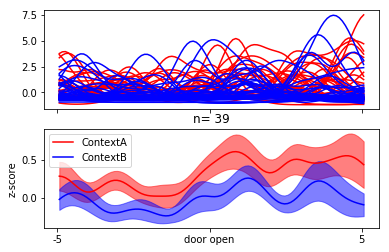

In [10]:
#Activated in A
event_response={'A':{'sig':[]},
                'B':{'sig':[]}}
for n,myUnit in enumerate(ensemble):
    #clean up unit marker, overwrite manual labeled event marker with auto detected ones

    trial=myUnit.split_trial()
    door_marker={'open':[ti['door_open'] for ti in trial],
                 'close':[ti['door_close'] for ti in trial],
                 'duration':myUnit.marker.door['duration']}
    event=door_marker['open'] #aligned by door open 
    response_temp={'A':{'sig':[],'delay':[]},
                        'B':{'sig':[],'delay':[]}}
    for num_trial,ctx in enumerate(myUnit.marker.protocol):
    
        if (entrydur_range[0]<=door_marker['duration'][num_trial]<=entrydur_range[1]): #first constraint on entry duration, second constraint on only using 1 trial for each context
            spkt=trial[num_trial]['spkt'] 
            spkt=np.extract(spkt<door_marker['close'][num_trial]+10,spkt) #only need spikes until 10s after door close                        
            if len(spkt)>=spkthreshold:
                ifr,ts=binned_FR(spkt,door_marker['close'][num_trial]+10,tbin,sigma=5) #turn spike train into continuous firing rate trace by averaging spike counts over tbin seconds, and smooth the trace with 1d Gaussian filter with sigma=5  
                zfr=zscore(ifr) #zscore normalization 
                z_event=np.extract(ts>=event[num_trial]-preevent,zfr)[:int((preevent+postevent)/tbin)+1] #extract peri-event signal 
                ts_event=np.extract(ts>=event[num_trial]-preevent,ts)[:int((preevent+postevent)/tbin)+1]-event[num_trial] 
                sig_t=np.extract(z_event>=sigthreshold,ts_event) #detect time points with significant activation 
                if (sig_t.size>0) & (np.max(z_event)<=20) & (ctx=='A'):
                    response_temp[ctx]['sig'].append(z_event)
                    response_temp[ctx]['delay'].append(sig_t[0])
                elif ctx=='B':
                    response_temp[ctx]['sig'].append(z_event)
                    try:
                        response_temp[ctx]['delay'].append(sig_t[0])
                    except:
                        response_temp[ctx]['delay'].append([])
                else:
                    pass
            
    if (np.size(response_temp['A']['delay'])>0) &(np.size(response_temp['B']['sig'])>0):
        event_response['A']['sig'].append(response_temp['A']['sig'][0]) 
        event_response['B']['sig'].append(response_temp['B']['sig'][0]) 
    else:
        pass

f,ax=plt.subplots(2,1,sharex=True)
for sig in event_response['A']['sig']:    
    ax[0].plot(ts_event,sig,color='r')
for sig in event_response['B']['sig']:    
    ax[0].plot(ts_event,sig,color='b')
plt.title('n= %d'%len(event_response['A']['sig']))
colors=['red','blue']
for ctx,color in zip(['A','B'],colors):
    sigmean=np.mean(event_response[ctx]['sig'],axis=0)
    sigerror=stats.sem(event_response[ctx]['sig'],axis=0)
    ax[1].plot(ts_event,sigmean,color=color)
    ax[1].fill_between(ts_event,sigmean+sigerror,sigmean-sigerror,color=color,alpha=0.5)
ax[1].set_xticks([-preevent,0,postevent])
ax[1].set_xticklabels([-preevent,'door open',postevent])
ax[1].set_ylabel('z-score')
ax[1].legend(['ContextA','ContextB'])
fig.savefig(os.path.join(pathname,'fig2.svg'),bbox_inches='tight',format='svg')

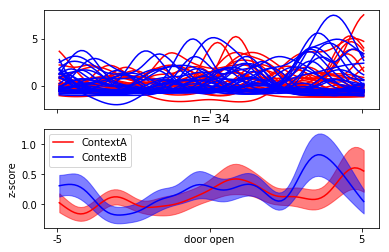

In [12]:
#Activated in B 
event_response={'A':{'sig':[]},
                'B':{'sig':[]}}
for n,myUnit in enumerate(ensemble):
    #clean up unit marker, overwrite manual labeled event marker with auto detected ones

    trial=myUnit.split_trial()
    door_marker={'open':[ti['door_open'] for ti in trial],
                 'close':[ti['door_close'] for ti in trial],
                 'duration':myUnit.marker.door['duration']}
    event=door_marker['open'] #aligned by door open 
    response_temp={'A':{'sig':[],'delay':[]},
                        'B':{'sig':[],'delay':[]}}
    for num_trial,ctx in enumerate(myUnit.marker.protocol):
    
        if (entrydur_range[0]<=door_marker['duration'][num_trial]<=entrydur_range[1]): #first constraint on entry duration, second constraint on only using 1 trial for each context
            spkt=trial[num_trial]['spkt'] 
            spkt=np.extract(spkt<door_marker['close'][num_trial]+10,spkt) #only need spikes until 10s after door close                        
            if len(spkt)>=spkthreshold:
                ifr,ts=binned_FR(spkt,door_marker['close'][num_trial]+10,tbin,sigma=5) #turn spike train into continuous firing rate trace by averaging spike counts over tbin seconds, and smooth the trace with 1d Gaussian filter with sigma=5  
                zfr=zscore(ifr) #zscore normalization 
                z_event=np.extract(ts>=event[num_trial]-preevent,zfr)[:int((preevent+postevent)/tbin)+1] #extract peri-event signal 
                ts_event=np.extract(ts>=event[num_trial]-preevent,ts)[:int((preevent+postevent)/tbin)+1]-event[num_trial] 
                sig_t=np.extract(z_event>=sigthreshold,ts_event) #detect time points with significant activation 
                if (sig_t.size>0) & (np.max(z_event)<=20) & (ctx=='B'):
                    response_temp[ctx]['sig'].append(z_event)
                    response_temp[ctx]['delay'].append(sig_t[0])
                elif ctx=='A':
                    response_temp[ctx]['sig'].append(z_event)
                    try:
                        response_temp[ctx]['delay'].append(sig_t[0])
                    except:
                        response_temp[ctx]['delay'].append([])
                else:
                    pass
            
    if (np.size(response_temp['B']['delay'])>0) &(np.size(response_temp['A']['sig'])>0):
        event_response['A']['sig'].append(response_temp['A']['sig'][0]) 
        event_response['B']['sig'].append(response_temp['B']['sig'][0]) 
    else:
        pass

f,ax=plt.subplots(2,1,sharex=True)
for sig in event_response['A']['sig']:    
    ax[0].plot(ts_event,sig,color='r')
for sig in event_response['B']['sig']:    
    ax[0].plot(ts_event,sig,color='b')
plt.title('n= %d'%len(event_response['A']['sig']))
colors=['red','blue']
for ctx,color in zip(['A','B'],colors):
    sigmean=np.mean(event_response[ctx]['sig'],axis=0)
    sigerror=stats.sem(event_response[ctx]['sig'],axis=0)
    ax[1].plot(ts_event,sigmean,color=color)
    ax[1].fill_between(ts_event,sigmean+sigerror,sigmean-sigerror,color=color,alpha=0.5)
ax[1].set_xticks([-preevent,0,postevent])
ax[1].set_xticklabels([-preevent,'door open',postevent])
ax[1].set_ylabel('z-score')
ax[1].legend(['ContextA','ContextB'])
fig.savefig(os.path.join(pathname,'fig3.svg'),bbox_inches='tight',format='svg')

## Aligned by context entering 

In [35]:
entrydur_range=[0,50]
####parameters initialization####
tbin=0.1 #firing rate average over tbin second window 
preevent=5
postevent=5
spkthreshold=20 #minimum spike count required
sigthreshold=1.65 #threshold for zscore response

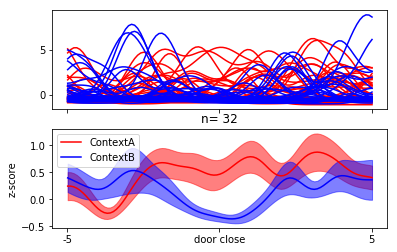

In [37]:
# significantly activated in context A 
event_response={'A':{'sig':[]},
                'B':{'sig':[]}}
for n,myUnit in enumerate(ensemble):
    trial=myUnit.split_trial()

    door_marker={'open':[ti['door_open'] for ti in trial],
                 'close':[ti['door_close'] for ti in trial],
                 'duration':myUnit.marker.door['duration']}
    #event=door_marker['close']
    event=myUnit.marker.enter_context['ts']
    
    response_temp={'A':{'sig':[],'delay':[]},
                        'B':{'sig':[],'delay':[]}}
    for num_trial,ctx in enumerate(myUnit.marker.protocol):
        if (entrydur_range[0]<=door_marker['duration'][num_trial]<=entrydur_range[1]): #first constraint on entry duration, second constraint on only using 1 trial for each context
            spkt=trial[num_trial]['spkt'] 
            spkt=np.extract(spkt<door_marker['close'][num_trial]+10,spkt) #only need spikes until 10s after door close                        
            if len(spkt)>=spkthreshold:
                ifr,ts=binned_FR(spkt,door_marker['close'][num_trial]+10,tbin,sigma=5) #turn spike train into continuous firing rate trace by averaging spike counts over tbin seconds, and smooth the trace with 1d Gaussian filter with sigma=5  
                zfr=zscore(ifr) #zscore normalization 
                z_event=np.extract(ts>=event[num_trial]-preevent,zfr)[:int((preevent+postevent)/tbin)+1] #extract peri-event signal 
                ts_event=np.extract(ts>=event[num_trial]-preevent,ts)[:int((preevent+postevent)/tbin)+1]-event[num_trial] 
                sig_t=np.extract(z_event>=sigthreshold,ts_event) #detect time points with significant activation 
                if (sig_t.size>0) & (np.max(z_event)<=20) & (ctx=='A'):
                    response_temp[ctx]['sig'].append(z_event)
                    response_temp[ctx]['delay'].append(sig_t[0])
                elif ctx=='B':
                    response_temp[ctx]['sig'].append(z_event)
                    try:
                        response_temp[ctx]['delay'].append(sig_t[0])
                    except:
                        response_temp[ctx]['delay'].append([])
                else:
                    pass
            
    if (np.size(response_temp['A']['delay'])>0)&(np.size(response_temp['B']['sig'])>0):
        event_response['A']['sig'].append(response_temp['A']['sig'][0]) 
        event_response['B']['sig'].append(response_temp['B']['sig'][0]) 
    else:
        pass

f,ax=plt.subplots(2,1,sharex=True)
for sig in event_response['A']['sig']:    
    ax[0].plot(ts_event,sig,color='r')
for sig in event_response['B']['sig']:    
    ax[0].plot(ts_event,sig,color='b')
plt.title('n= %d'%len(event_response['A']['sig']))
colors=['red','blue']
for ctx,color in zip(['A','B'],colors):
    sigmean=np.mean(event_response[ctx]['sig'],axis=0)
    sigerror=stats.sem(event_response[ctx]['sig'],axis=0)
    ax[1].plot(ts_event,sigmean,color=color)
    ax[1].fill_between(ts_event,sigmean+sigerror,sigmean-sigerror,color=color,alpha=0.5)
ax[1].set_xticks([-preevent,0,postevent])
ax[1].set_xticklabels([-preevent,'door close',postevent])
ax[1].set_ylabel('z-score')
ax[1].legend(['ContextA','ContextB'])
fig.savefig(os.path.join(pathname,'fig4.svg'),bbox_inches='tight',format='svg')

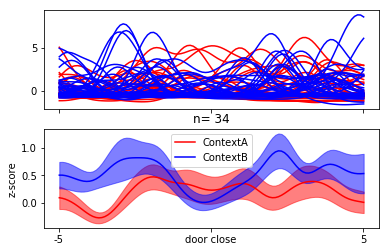

In [38]:
# significantly activated in context B
event_response={'A':{'sig':[]},
                'B':{'sig':[]}}
for n,myUnit in enumerate(ensemble):
    trial=myUnit.split_trial()

    door_marker={'open':[ti['door_open'] for ti in trial],
                 'close':[ti['door_close'] for ti in trial],
                 'duration':myUnit.marker.door['duration']}
    #event=door_marker['close']
    event=myUnit.marker.enter_context['ts']
    
    response_temp={'A':{'sig':[],'delay':[]},
                        'B':{'sig':[],'delay':[]}}
    for num_trial,ctx in enumerate(myUnit.marker.protocol):
        if (entrydur_range[0]<=door_marker['duration'][num_trial]<=entrydur_range[1]): #first constraint on entry duration, second constraint on only using 1 trial for each context
            spkt=trial[num_trial]['spkt'] 
            spkt=np.extract(spkt<door_marker['close'][num_trial]+10,spkt) #only need spikes until 10s after door close                        
            if len(spkt)>=spkthreshold:
                ifr,ts=binned_FR(spkt,door_marker['close'][num_trial]+10,tbin,sigma=5) #turn spike train into continuous firing rate trace by averaging spike counts over tbin seconds, and smooth the trace with 1d Gaussian filter with sigma=5  
                zfr=zscore(ifr) #zscore normalization 
                z_event=np.extract(ts>=event[num_trial]-preevent,zfr)[:int((preevent+postevent)/tbin)+1] #extract peri-event signal 
                ts_event=np.extract(ts>=event[num_trial]-preevent,ts)[:int((preevent+postevent)/tbin)+1]-event[num_trial] 
                sig_t=np.extract(z_event>=sigthreshold,ts_event) #detect time points with significant activation 
                if (sig_t.size>0) & (np.max(z_event)<=20) & (ctx=='B'):
                    response_temp[ctx]['sig'].append(z_event)
                    response_temp[ctx]['delay'].append(sig_t[0])
                elif ctx=='A':
                    response_temp[ctx]['sig'].append(z_event)
                    try:
                        response_temp[ctx]['delay'].append(sig_t[0])
                    except:
                        response_temp[ctx]['delay'].append([])
                else:
                    pass
            
    if (np.size(response_temp['B']['delay'])>0)&(np.size(response_temp['A']['sig'])>0):
        event_response['A']['sig'].append(response_temp['A']['sig'][0]) 
        event_response['B']['sig'].append(response_temp['B']['sig'][0]) 
    else:
        pass

f,ax=plt.subplots(2,1,sharex=True)
for sig in event_response['A']['sig']:    
    ax[0].plot(ts_event,sig,color='r')
for sig in event_response['B']['sig']:    
    ax[0].plot(ts_event,sig,color='b')
plt.title('n= %d'%len(event_response['A']['sig']))
colors=['red','blue']
for ctx,color in zip(['A','B'],colors):
    sigmean=np.mean(event_response[ctx]['sig'],axis=0)
    sigerror=stats.sem(event_response[ctx]['sig'],axis=0)
    ax[1].plot(ts_event,sigmean,color=color)
    ax[1].fill_between(ts_event,sigmean+sigerror,sigmean-sigerror,color=color,alpha=0.5)
ax[1].set_xticks([-preevent,0,postevent])
ax[1].set_xticklabels([-preevent,'door close',postevent])
ax[1].set_ylabel('z-score')
plt.legend(['ContextA','ContextB'])
fig.savefig(os.path.join(pathname,'fig5.svg'),bbox_inches='tight',format='svg')

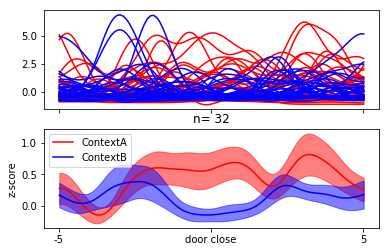

In [39]:
# significantly activated in context A, response averaged 
event_response={'A':{'sig':[]},
                'B':{'sig':[]}}
for n,myUnit in enumerate(ensemble):
    trial=myUnit.split_trial()

    door_marker={'open':[ti['door_open'] for ti in trial],
                 'close':[ti['door_close'] for ti in trial],
                 'duration':myUnit.marker.door['duration']}
    #event=door_marker['close']
    event=myUnit.marker.enter_context['ts']
    
    response_temp={'A':{'sig':[],'delay':[]},
                        'B':{'sig':[],'delay':[]}}
    for num_trial,ctx in enumerate(myUnit.marker.protocol):
        if (entrydur_range[0]<=door_marker['duration'][num_trial]<=entrydur_range[1]): #first constraint on entry duration, second constraint on only using 1 trial for each context
            spkt=trial[num_trial]['spkt'] 
            spkt=np.extract(spkt<door_marker['close'][num_trial]+10,spkt) #only need spikes until 10s after door close                        
            if len(spkt)>=spkthreshold:
                ifr,ts=binned_FR(spkt,door_marker['close'][num_trial]+10,tbin,sigma=5) #turn spike train into continuous firing rate trace by averaging spike counts over tbin seconds, and smooth the trace with 1d Gaussian filter with sigma=5  
                zfr=zscore(ifr) #zscore normalization 
                z_event=np.extract(ts>=event[num_trial]-preevent,zfr)[:int((preevent+postevent)/tbin)+1] #extract peri-event signal 
                ts_event=np.extract(ts>=event[num_trial]-preevent,ts)[:int((preevent+postevent)/tbin)+1]-event[num_trial] 
                sig_t=np.extract(z_event>=sigthreshold,ts_event) #detect time points with significant activation 
                if (sig_t.size>0) & (np.max(z_event)<=20) & (ctx=='A'):
                    response_temp[ctx]['sig'].append(z_event)
                    response_temp[ctx]['delay'].append(sig_t[0])
                elif ctx=='B':
                    response_temp[ctx]['sig'].append(z_event)
                    try:
                        response_temp[ctx]['delay'].append(sig_t[0])
                    except:
                        response_temp[ctx]['delay'].append([])
                else:
                    pass
            
    if (np.size(response_temp['A']['delay'])>0)&(np.size(response_temp['B']['sig'])>0):
        event_response['A']['sig'].append(np.mean(response_temp['A']['sig'],axis=0)) 
        event_response['B']['sig'].append(np.mean(response_temp['B']['sig'],axis=0)) 
    else:
        pass

f,ax=plt.subplots(2,1,sharex=True)
for sig in event_response['A']['sig']:    
    ax[0].plot(ts_event,sig,color='r')
for sig in event_response['B']['sig']:    
    ax[0].plot(ts_event,sig,color='b')
plt.title('n= %d'%len(event_response['A']['sig']))
colors=['red','blue']
for ctx,color in zip(['A','B'],colors):
    sigmean=np.mean(event_response[ctx]['sig'],axis=0)
    sigerror=stats.sem(event_response[ctx]['sig'],axis=0)
    ax[1].plot(ts_event,sigmean,color=color)
    ax[1].fill_between(ts_event,sigmean+sigerror,sigmean-sigerror,color=color,alpha=0.5)
ax[1].set_xticks([-preevent,0,postevent])
ax[1].set_xticklabels([-preevent,'door close',postevent])
ax[1].set_ylabel('z-score')
ax[1].legend(['ContextA','ContextB'])
fig.savefig(os.path.join(pathname,'fig6.svg'),bbox_inches='tight',format='svg')